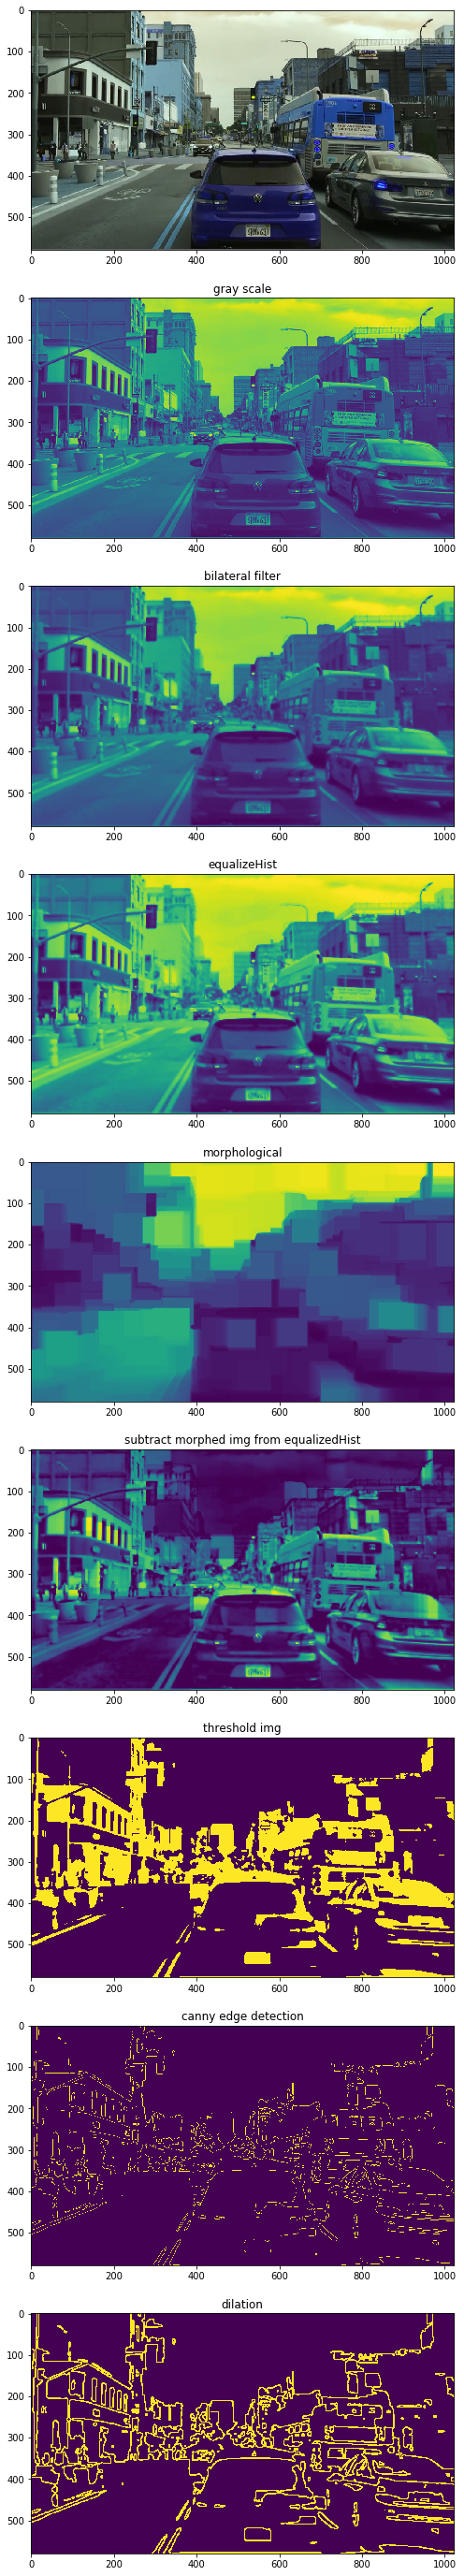

In [2]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

%matplotlib inline

IMG = os.path.join("../","images","new_scene.png")

img = cv2.imread(IMG, cv2.IMREAD_COLOR)

fig = plt.figure(figsize=(50,50))

fig.add_subplot(9,1,1).imshow(img)

# RGB to Gray scale conversion
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
fig.add_subplot(9,1,2).imshow(img_gray)
plt.title('gray scale')

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
noise_removal = cv2.bilateralFilter(img_gray,9,75,75)
fig.add_subplot(9,1,3).imshow(noise_removal)
plt.title('bilateral filter')

# Histogram equalisation for better results
equal_histogram = cv2.equalizeHist(noise_removal)
fig.add_subplot(9,1,4).imshow(equal_histogram)
plt.title('equalizeHist')

# Morphological opening with a rectangular structure element
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
morph_image = cv2.morphologyEx(equal_histogram,cv2.MORPH_OPEN,kernel,iterations=15)
fig.add_subplot(9,1,5).imshow(morph_image)
plt.title('morphological')

# Image subtraction(Subtracting the Morphed image from the histogram equalised Image)
sub_morp_image = cv2.subtract(equal_histogram,morph_image)
fig.add_subplot(9,1,6).imshow(sub_morp_image)
plt.title('subtract morphed img from equalizedHist')

# Thresholding the image
ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_OTSU)
fig.add_subplot(9,1,7).imshow(thresh_image)
plt.title('threshold img')

# Applying Canny Edge detection
canny_image = cv2.Canny(thresh_image,250,255)
fig.add_subplot(9,1,8).imshow(canny_image)
plt.title('canny edge detection')

# dilation to strengthen the edges
kernel = np.ones((3,3), np.uint8)
dilated_image = cv2.dilate(canny_image,kernel,iterations=1)
fig.add_subplot(9,1,9).imshow(dilated_image)
plt.title('dilation')

plt.show()

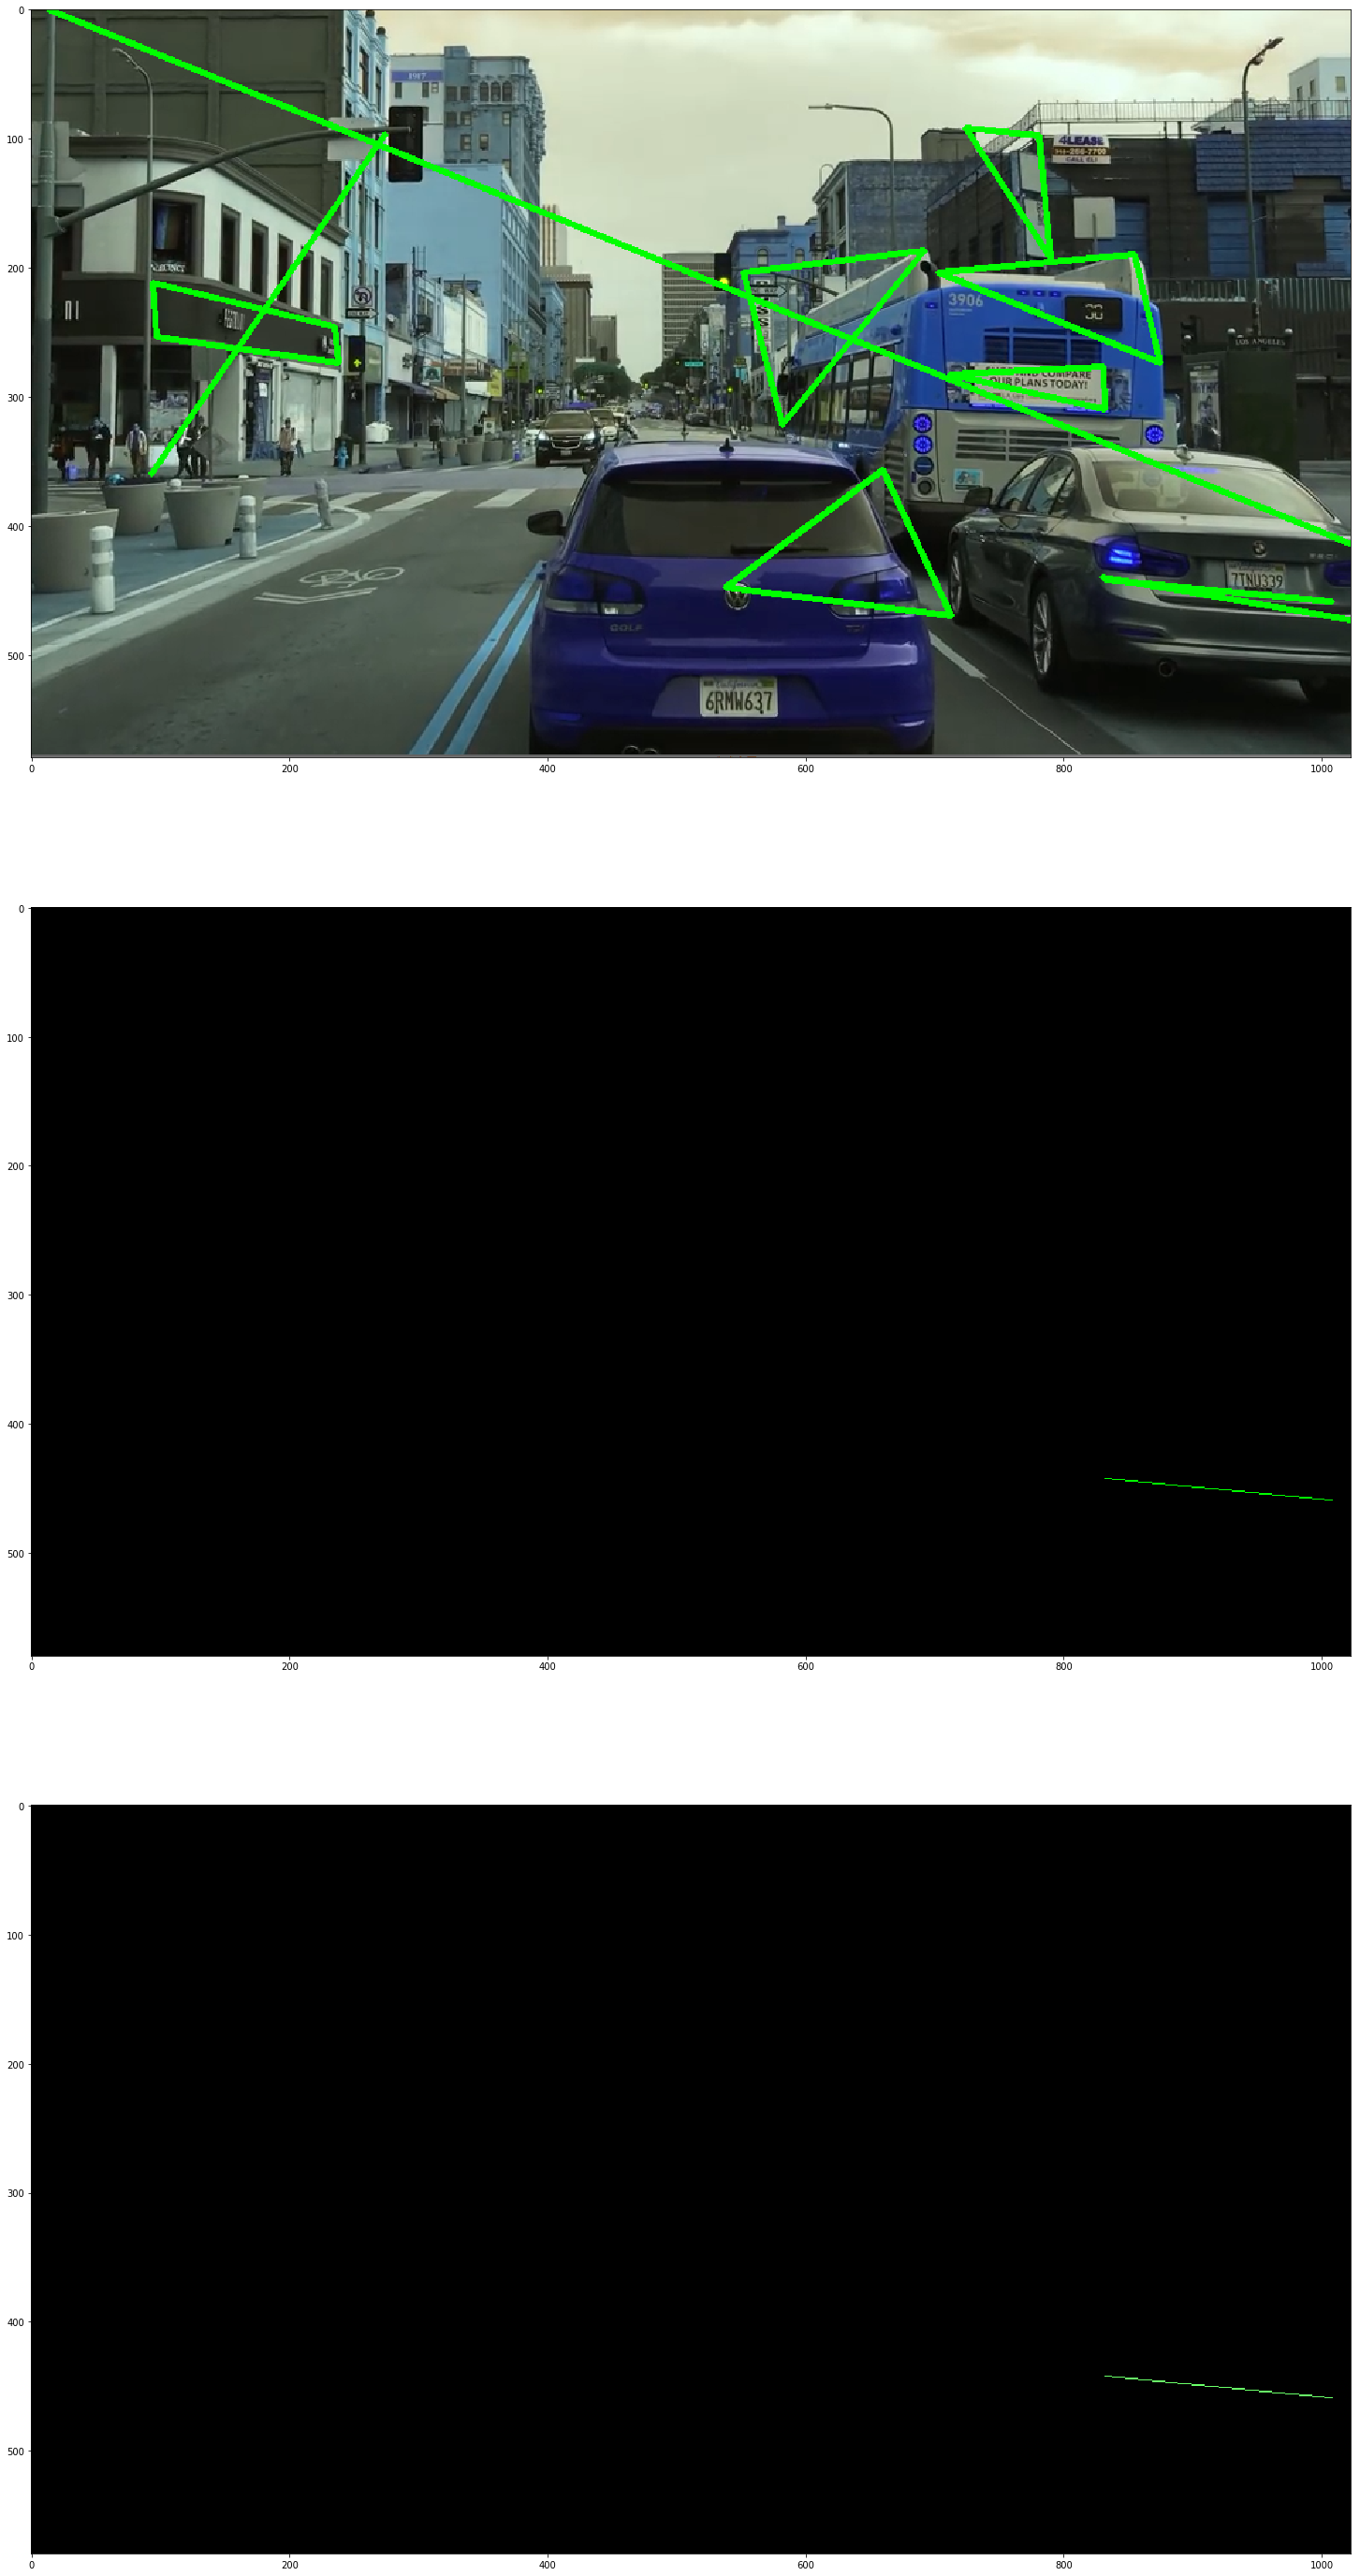

In [104]:
# Finding Contours in the image based on edges
new,contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:10]

final = img
screenCnt = None

for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.06 * peri, True)  # Approximating with 6% error
    screenCnt = approx
    final = cv2.drawContours(final, [approx], -1, (0, 255, 0), 3) 
    
fig = plt.figure(figsize=(50, 50))
fig.add_subplot(3,1,1).imshow(final)


# Masking the part other than the number plate
mask = np.zeros(img_gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
new_image = cv2.bitwise_and(img,img,mask=mask)
fig.add_subplot(3,1,2).imshow(new_image)


# Histogram equal for enhancing the number plate for further processing
y,cr,cb = cv2.split(cv2.cvtColor(new_image,cv2.COLOR_RGB2YCrCb))
# Converting the image to YCrCb model and splitting the 3 channels
y = cv2.equalizeHist(y)
# Applying histogram equalisation
final_image = cv2.cvtColor(cv2.merge([y,cr,cb]),cv2.COLOR_YCrCb2RGB)

fig.add_subplot(3,1,3).imshow(final_image)
plt.show()

### Code to automatically segment numbers from numberplates by finding contours


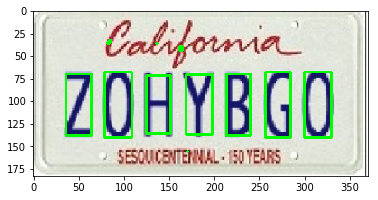

In [105]:
IMG = os.path.join("../","images","new_plate.png")

img = cv2.imread(IMG)

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
noise_removal = cv2.bilateralFilter(gray_img,9,75,75)
ret,thresh_image = cv2.threshold(noise_removal,70,255,cv2.THRESH_BINARY_INV)

new,contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours= sorted(contours, key = cv2.contourArea, reverse = True)

for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(img)
plt.show()

In [106]:
# randomly generate number plates

from random import randint
 
def gen_plate_number(noc=7):    
    
    CANDIDATES = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    NO_OF_CHARS = noc                                   
    
    plate = ""
    for ch in range(NO_OF_CHARS):
        num = randint(0,35)
        plate += CANDIDATES[num]
        
    return plate

print(gen_plate_number())

M91LYOP


In [107]:
import pickle
import requests
from bs4 import BeautifulSoup
from PIL import Image
import tensorflow as tf
%matplotlib inline 

CHARACTERS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
N_CLASSES = 36

In [108]:
def read_dataset(fname="number_plates_new.pickle",N=None):
    f = open(fname,'rb')
    X_data,Y_label = pickle.load(f)
    if not N is None:
        return X_data[:N],Y_label[:N]
    else:
        return X_data, Y_label

In [109]:
html = requests.get("http://acme.com/licensemaker/licensemaker.cgi", 
            params={
                "state" : "California",
                "text"  : 123456, 
                "plate" : "1998",
                "r"     : "1014181821"
            }).text
    
soup = BeautifulSoup(html,"html5lib")
soup('img')

[<img alt="atom" class="logo" height="86" src="/resources/images/atom_ani.gif" width="86"/>,
 <img alt="license maker" height="50" src="licensemaker.jpg" width="228"/>,
 <img alt="license" src="licenses/license_20180213175935_23487.jpg"/>,
 <img alt="valid HTML" border="0" class="logo" height="31" src="/resources/images/valid-html401-gold.png" width="88"/>,
 <img alt="email" class="mailto" src="/mailto/wa.gif"/>]

In [110]:
def generate_plate(plate_num):
    html = requests.get("http://acme.com/licensemaker/licensemaker.cgi", 
            params={
                "state" : "California",
                "text"  : plate_num, 
                "plate" : "1998",
                "r"     : "1014181821"
            }).text
    
    soup = BeautifulSoup(html,"html5lib")
    
    URL_DOM = "http://acme.com/licensemaker/"
    URL_IMG = soup('img')[2]['src']
    URL = URL_DOM + URL_IMG
    
    # Fetching the image from the web 
    response = requests.get(URL)
    if response.status_code == 200: # no server error
        img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        return np.array(cv2.imdecode(img_array, cv2.IMREAD_COLOR)),plate_num
    
    # if server error
    return None,plate_num

In [111]:
def contour_center(cnt):
    
    # finding the moments of the contour
    M = cv2.moments(cnt)
    
    if M["m00"] != 0:
        # center x
        cX = int(M["m10"] / M["m00"])
    else:
        cX = 0
    
    return cX

In [112]:
def one_hot_encoded(label_lst,classes=N_CLASSES):
    return list(np.eye(classes)[label_lst])

In [113]:
def get_code(ch):
    OFFSET = 10
    if ch.isdigit():
        return ord(ch) - ord('0')
    else:
        return OFFSET + (ord(ch) - ord('A'))

In [114]:
def get_img_label(img,plate_num):
    
    x_list, y_list = [], []
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    noise_removal = cv2.bilateralFilter(img,9,75,75)
    
    ret,thresh_image = cv2.threshold(noise_removal,70,255,cv2.THRESH_BINARY_INV)

    new,contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # contours sorted by their centers
    contours= sorted(contours, key = contour_center)[:7]
    
    for idx,cnt in enumerate(contours):
        
        x,y,w,h = cv2.boundingRect(cnt)
        
        part = img[y : y + h, x : x + w]
        
        part = cv2.resize(part,(40,18))
        
        _,part = cv2.threshold(part,128,255,cv2.THRESH_BINARY_INV)
        
        part = cv2.normalize(part, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        x_list.append(list(part))
        
        y_list.append(one_hot_encoded(get_code(num[idx])))
    
    return x_list, y_list

In [115]:
def gen_training_dataset(runs,fname="number_plates_new.pickle"):
    X_data, Y_data = [], []
    
    if os.path.exists(fname):
        with open(fname,'rb') as rfp: 
            X_data, Y_data = ( list(data) for data in pickle.load(rfp) )
        rfp.close()
        
    print(len(X_data), len(Y_data))
    
    for idx in range(runs):
        
        # generating a new number
        num = gen_plate_number()
        img, num = generate_plate(num)
        
        x_list,y_list = get_img_label(img,num)
        
        X_data.extend(x_list)
        Y_data.extend(y_list)
    
    f = open(fname, 'wb')   
    pickle.dump((np.array(X_data), np.array(Y_data)), f)
    f.close()

In [116]:
def one_hot_decode(lst):
    return np.argmax(lst)

In [117]:
def get_char(num):
    OFFSET = 10
    if num < 10:
        return chr(ord('0') + num) # converting the number to char 
    else:
        return chr(ord('A') + num - OFFSET)


In [118]:
def display_plate_numbers(img,num):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    noise_removal = cv2.bilateralFilter(gray_img,9,75,75)
    ret,thresh_image = cv2.threshold(noise_removal,70,255,cv2.THRESH_BINARY_INV)

    new,contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # contours sorted by their centers
    contours= sorted(contours, key = contour_center)[:7]
    
    fig = plt.figure()
    
    for idx,cnt in enumerate(contours):
        x,y,w,h = cv2.boundingRect(cnt)
        part = img[y : y + h, x : x + w]
        part = cv2.cvtColor(part,cv2.COLOR_BGR2GRAY)
        _,part = cv2.threshold(part,128,255,cv2.THRESH_BINARY_INV)
        fig.add_subplot(4,2,idx+1).imshow(part)
    plt.show()


def display_plate(img,num):
    print("Plate Label : ", num )
    plt.imshow(img)
    plt.show()

def display_plate_detected(img):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    noise_removal = cv2.bilateralFilter(gray_img,9,75,75)
    ret,thresh_image = cv2.threshold(noise_removal,70,255,cv2.THRESH_BINARY)

    new,contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours= sorted(contours, key = cv2.contourArea, reverse = True)

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

    plt.gray()
    plt.imshow(img)
    plt.show()

Plate Label :  BAK90R6


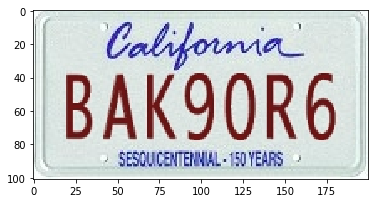

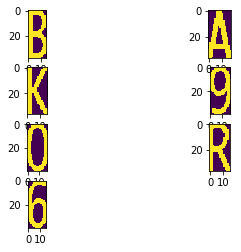

In [119]:
img,num = generate_plate(gen_plate_number())
display_plate(img,num)
display_plate_numbers(img,num)

In [120]:
# import os
# fname = "number_plates_new.pickle"
# gen_training_dataset(100, fname)

In [121]:
# Reading Dataset
X_data,Y_label = read_dataset(fname)
print(X_data.shape, Y_label.shape)

(4900, 18, 40) (4900, 36)


Q


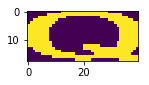

B


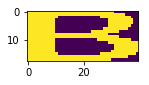

Q


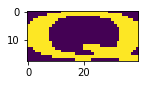

E


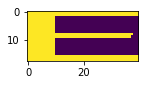

X


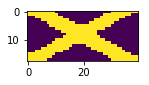

In [122]:
fname = "number_plates_new.pickle"
X_data,Y_label = read_dataset(fname,5)

for image, label in zip(X_data,Y_label):
    print(get_char(one_hot_decode(label)))
    plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.show()

In [123]:
X_data,Y_label = read_dataset()

def read_data_sets(num):
    
    cars = {}
    i = 0
    
    for image, label in zip(X_data, Y_label):
        if i < num:
            if not 'train' in cars:
                cars['train'] = {'images': [], 'labels': []}
            cars['train']['images'].append(image.flatten())
            cars['train']['labels'].append(label)
        else:
            if not 'test' in cars:
                cars['test'] = {'images': [], 'labels': []}
            cars['test']['images'].append(image.flatten())
            cars['test']['labels'].append(label)
        
        i+=1
        
    cars['train']['images'] = np.array(cars['train']['images'])
    cars['train']['labels'] = np.array(cars['train']['labels'])
    cars['test']['images']  = np.array(cars['test']['images'])
    cars['test']['labels']  = np.array(cars['test']['labels'])
        
    return cars


cars = read_data_sets(4850)

print(cars['train']['images'].shape)
print(cars['train']['labels'].shape)
print(cars['test']['images'].shape)
print(cars['test']['labels'].shape)

(4850, 720)
(4850, 36)
(50, 720)
(50, 36)


In [153]:
#### Create the model
x = tf.placeholder(tf.float32, [None, 720])
W = tf.Variable(tf.zeros([720, 36]))
b = tf.Variable(tf.zeros([36]))
y = tf.matmul(x, W) + b

y_ = tf.placeholder(tf.float32, [None, 36])

cross_entropy = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

train = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

saver = tf.train.Saver()
    
# Train
batch_xs, batch_ys = cars['train']['images'], cars['train']['labels']

sess.run(train, feed_dict={x: batch_xs, y_: batch_ys})

# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={x: cars['test']['images'],
                                          y_: cars['test']['labels']}))

0.76


In [151]:
directory="model/plate_model.ckpt"
if not os.path.exists(directory):
    os.makedirs(directory)
save_path = saver.save(sess, directory)
print("Model saved in file: %s" % save_path)

Model saved in file: model/plate_model.ckpt


O
(18, 40)


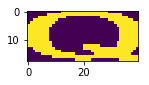

B
(18, 40)


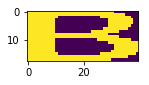

O
(18, 40)


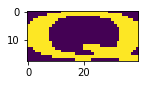

E
(18, 40)


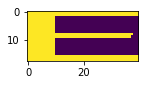

X
(18, 40)


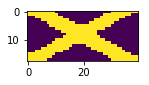

G
(18, 40)


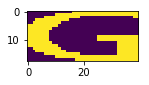

S
(18, 40)


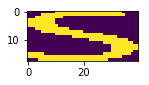

4
(18, 40)


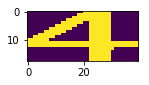

G
(18, 40)


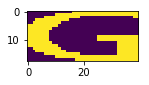

E
(18, 40)


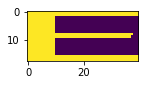

In [154]:

def predictint(imvalue):
    """
    This function returns the predicted integer.
    The input is the pixel values from the imageprepare() function.
    """            
    prediction=tf.argmax(y,1)
    return prediction.eval(feed_dict={x: [imvalue]}, session=sess)

# Test images generation

X_data,Y_label = read_dataset(fname,10)

for image, label in zip(X_data,Y_label):
    imvalue = np.array(image).flatten()
    
    label = predictint(imvalue)
    print(get_char(label[0]))
    plt.figure(figsize=(2,2))
    print(image.shape)
    plt.imshow(image)
    plt.show()

In [167]:
# Training the characters for MNIST

import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Create the model
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
    
# Train
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(mnist.test.images.shape, mnist.test.labels.shape)

print(sess.run(accuracy, feed_dict={x: mnist.test.images,
                                          y_: mnist.test.labels}))

directory="model/mnist_plate_model.ckpt"
if not os.path.exists(directory):
    os.makedirs(directory)
save_path = saver.save(sess, directory)
print("Model saved in file: %s" % save_path)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(10000, 784) (10000, 10)
0.9144
Model saved in file: model/mnist_plate_model.ckpt


7


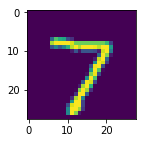

2


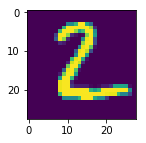

1


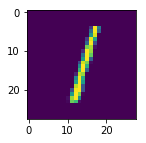

0


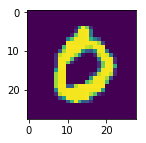

4


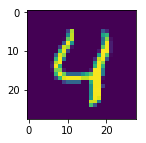

1


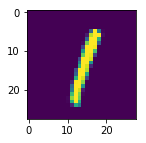

4


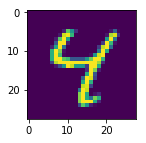

9


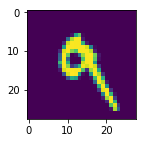

6


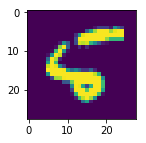

9


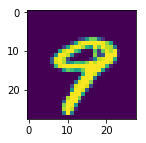

In [133]:
tf_keras = tf.contrib.keras
fig = plt.figure(figsize=(10,10))

(x_train, y_train), (x_test, y_test) = tf_keras.datasets.mnist.load_data(
    "mnist.npz")

def predictint2(imvalue):
    """
    This function returns the predicted integer.
    The input is the pixel values from the imageprepare() function.
    """
    prediction=tf.argmax(y,1)
    return prediction.eval(feed_dict={x: [imvalue]}, session=sess)

# Test images generation
X_data,Y_label = x_test[:10], y_test[:10]

for image, label in zip(X_data,Y_label):
    imvalue = np.array(image).flatten()
    label = predictint2(imvalue)
    print(get_char(label[0]))
    plt.figure(figsize=(2,2))
    image= cv2.resize(image, (28, 28))
    plt.imshow(image)
    plt.show()

In [134]:
def match_area(cnt):
    area = cv2.contourArea(cnt) 
    return area >= 1400 and area <= 2000

In [183]:
def predict_number(img):
    
    detected_number = ''
     
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    equal_histogram = cv2.equalizeHist(img_gray)
    
    ret,thresh_image = cv2.threshold(equal_histogram,50,255,cv2.THRESH_BINARY_INV)
  
    new, contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    print("found {} contours: ".format(len(contours)))
    contours= sorted(contours, key = contour_center)
      
    count = 0
    
    fig = plt.figure("Input Image",figsize=(10,10))
          
    for idx, cnt in enumerate(contours):
        
        p,q,w,h = cv2.boundingRect(cnt)
        
        aspect_ratio = h / w
            
        if aspect_ratio >= 2.1 and aspect_ratio <= 2.85:
            
            count += 1
        
            part = img_gray[q : q + h, p : p + w]
            
            cv2.rectangle(img,(p,q),(p+w,q+h),(0,255,0),1)
            
            # Resize when using custom model
            #part = cv2.resize(part,(40,18), interpolation=cv2.INTER_NEAREST)
            
            # Resize to MNIST model
            part = cv2.resize(part,(28,28), interpolation=cv2.INTER_NEAREST)
            
            _,part = cv2.threshold(part,128,255,cv2.THRESH_BINARY_INV)
            
            
            # lets do erosion
            kernel = np.ones((3,3),np.uint8)
            part = cv2.erode(part,kernel,iterations = 1)

            part = cv2.normalize(part, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

            label = predictint2(part.flatten())
            label = get_char(label[0])
            
            detected_number += label

            fig.add_subplot(4,4,idx+1).imshow(part)
            
        plt.show()
    
    return detected_number
    

found 16 contours: 
5555555
No of number plates detected : 1


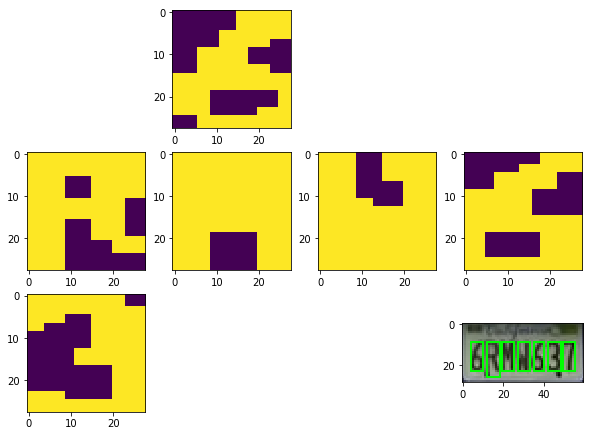

In [200]:
def predict_number(img):
    
    detected_number = ''
     
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    equal_histogram = cv2.equalizeHist(img_gray)
    
    ret,thresh_image = cv2.threshold(equal_histogram,50,255,cv2.THRESH_BINARY_INV)
  
    new, contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    print("found {} contours: ".format(len(contours)))
    contours= sorted(contours, key = contour_center)
      
    count = 0
    
    fig = plt.figure("Input Image",figsize=(10,10))
          
    for idx, cnt in enumerate(contours):
        
        p,q,w,h = cv2.boundingRect(cnt)
        
        aspect_ratio = h / w
            
        if aspect_ratio >= 2.1 and aspect_ratio <= 2.85:
            
            count += 1
        
            part = img_gray[q : q + h, p : p + w]
            
            cv2.rectangle(img,(p,q),(p+w,q+h),(0,255,0),1)
            
            # Resize when using custom model
            #part = cv2.resize(part,(40,18), interpolation=cv2.INTER_NEAREST)
            
            # Resize to MNIST model
            part = cv2.resize(part,(28,28), interpolation=cv2.INTER_NEAREST)
            
            _,part = cv2.threshold(part,128,255,cv2.THRESH_BINARY_INV)
            
            
            # lets do erosion
            kernel = np.ones((3,3),np.uint8)
            part = cv2.erode(part,kernel,iterations = 1)

            part = cv2.normalize(part, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

            label = predictint2(part.flatten())
            label = get_char(label[0])
            
            detected_number += label

            fig.add_subplot(4,4,idx+1).imshow(part)
    
    return detected_number
    
IMG = os.path.join("../","images","new_scene.png")

img = cv2.imread(IMG)

# Gray Image
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Histogram equalisation for better results
equal_histogram = cv2.equalizeHist(img_gray)

_, thres_image = cv2.threshold(equal_histogram, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

new, contours, hierarchy = cv2.findContours(thres_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

num_plates = 0


fig = plt.figure("Input Image",figsize=(10,10))

for cnt in contours:
    rect = cv2.minAreaRect(cnt)
    width = rect[1][0]
    height = rect[1][1]
    
    area = cv2.contourArea(cnt) 
    if area >= 1400 and area <= 1500:
            
        num_plates += 1
        
        p,q,w,h = cv2.boundingRect(cnt)
        
        part = img[q : q + h, p : p + w]
        
        number=predict_number(part)
        
        print(number)
        
        plt.imshow(part)

    
print("No of number plates detected : {0}".format(num_plates))

plt.show()


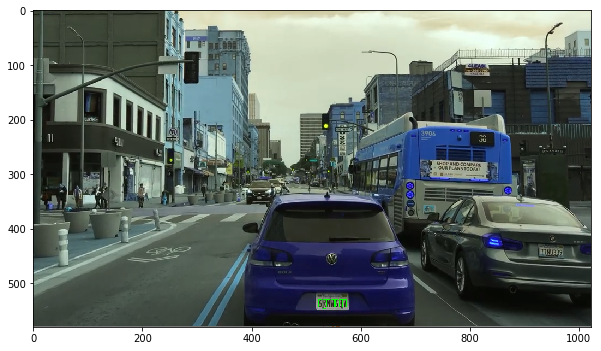

In [201]:
fig = plt.figure("Input Image",figsize=(10,10))
fig.add_subplot(1,1,1).imshow(img)

plt.show()

### Try CNN

In [1]:
# MNIST CNN - Loading Data

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


(28, 28)
9


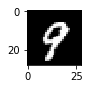

In [4]:
import random

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

print(image.shape)
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [5]:
import sys
import time
import tensorflow as tf

EPOCHS = 10
DROPOUT = 0.5
BATCH_SIZE = 100
SCALE = 0.1 # Scaling to 
LEARNING_RATE = 1e-4
FLAGS=None

In [6]:
def conv2d(x, W):
    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [7]:
def max_pool_2x2(x):
    
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [9]:
def weight_variable(shape):
    
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [10]:
def bias_variable(shape):
    
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [12]:
def model(x):

    x_image = tf.reshape(x, [-1, 28, 28, 1])

    
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    
    h_pool1 = max_pool_2x2(h_conv1)

    
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    
    h_pool2 = max_pool_2x2(h_conv2)

    
    
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    
    
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    return y_conv, keep_prob

In [23]:
mnist = input_data.read_data_sets("MNIST_data/",  one_hot=True)


x = tf.placeholder(tf.float32, [None, 784])


y_ = tf.placeholder(tf.float32, [None, 10])


y_conv, keep_prob = model(x)

cross_entropy = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()


for epoch in range(EPOCHS):
    batch_count = int(mnist.train.num_examples/BATCH_SIZE)
    for i in range(int(batch_count * SCALE)):
        batch = mnist.train.next_batch(BATCH_SIZE)
        train_accuracy = accuracy.eval(feed_dict={ x: batch[0], y_: batch[1], keep_prob: 1.0})
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: DROPOUT})
    print('Epoch %d, training accuracy %g' % (epoch, train_accuracy))
            
    
print('Test accuracy %g' % accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

    
save_path = saver.save(sess, "Models/mnist_dnn.ckpt")
print ("Model saved in file: ", save_path)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 0, training accuracy 0.81
Epoch 1, training accuracy 0.93
Epoch 2, training accuracy 0.93
Epoch 3, training accuracy 0.95
Epoch 4, training accuracy 0.9
Epoch 5, training accuracy 0.96
Epoch 6, training accuracy 0.95
Epoch 7, training accuracy 0.97
Epoch 8, training accuracy 0.94
Epoch 9, training accuracy 0.97
Test accuracy 0.958
Model saved in file:  Models/mnist_dnn.ckpt


In [24]:
batch = mnist.train.next_batch(1)
print(batch[0].shape)
print(batch[1].shape)

(1, 784)
(1, 10)


In [26]:
sess = tf.InteractiveSession()

init_op = tf.global_variables_initializer()

saver = tf.train.Saver()

sess.run(init_op)

saver.restore(sess, "Models/mnist_dnn.ckpt")


def predictint2(imvalue):
               
    prediction=tf.argmax(y_conv,1)
    return prediction.eval(feed_dict={x: [imvalue]}, session=sess)

# Test images generation

X_data,Y_label = mnist.train.next_batch(1)

for imvalue, label in zip(X_data,Y_label):
    #imvalue = np.array(image).flatten()
    
    label = predictint2(imvalue)
    
    print(label)
    plt.imshow(image)
    plt.show()

INFO:tensorflow:Restoring parameters from Models/mnist_dnn.ckpt


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_14' with dtype float
	 [[Node: Placeholder_14 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: ArgMax_15/_263 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_69_ArgMax_15", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_14', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/karen/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/karen/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/karen/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/karen/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/karen/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/karen/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/karen/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/karen/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/karen/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/karen/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/karen/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/karen/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/karen/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/karen/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-b449a54a5de7>", line 10, in <module>
    y_conv, keep_prob = model(x)
  File "<ipython-input-12-6ecd39a7883f>", line 31, in model
    keep_prob = tf.placeholder(tf.float32)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_14' with dtype float
	 [[Node: Placeholder_14 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: ArgMax_15/_263 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_69_ArgMax_15", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
